## Primary Task 1

In [1138]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf) 

In [1139]:
def arrival_time(lambda_):
    return np.random.exponential(1 / lambda_)

In [1140]:
def time_of_stay(mu):
    return np.random.exponential(mu)

In [1141]:
def simulate_arrival_time_day(lambda_, days_simulation):

    total = 0
    arrivals_time = []

    while total < days_simulation:
        time_arrival = arrival_time(lambda_)
        arrivals_time.append(time_arrival)

        total += time_arrival

    return np.array(np.cumsum(arrivals_time))

In [1142]:
def extract_new_ward(patient, transition_probability):

    possible_wards = np.arange(0, transition_probability.shape[0])
    new_ward = np.random.choice(possible_wards, p=transition_probability[patient, : ])

    return new_ward

In [1143]:
def list_arrive_patient(arrivals_time):
    result = []
    for idx, sublist in enumerate(arrivals_time):
        for value in sublist:
            result.append((value, idx))
    
    # Sort by arrival time (first element of tuple)
    result.sort()
    return result

In [1144]:
def count_new_departures(leaving_time, processed, current_time, n_types):
    departures_count = [0] * n_types

    for i, (t, p_type) in enumerate(leaving_time):
        if not processed[i] and t < current_time:
            departures_count[p_type] += 1
            processed[i] = True  # mark as processed

    return departures_count, processed

In [1145]:
def simulate(
    transition_probability,
    lambdas,
    mean_length_stay,
    bed_capacity,
    days_simulation
):
    n_types = len(lambdas)
    type_patients = np.arange(n_types)

    occupied_bed = np.zeros(n_types, dtype=int)
    rejected_patients = np.zeros(n_types, dtype=int)

    # Time-tracking
    occupied_bed_timeline = []
    rejected_patients_timeline = []
    time_timeline = []

    # Relocation tracking: [original_type, relocated_to]
    relocated_patients = np.zeros((n_types, n_types), dtype=int)

    # Simulate arrivals per type
    arrival_time_total = [
        simulate_arrival_time_day(lambdas[tp], days_simulation)
        for tp in type_patients
    ]
    mix_arrivals_time = list_arrive_patient(arrival_time_total)
    # Leave tracking
    leaving_time = []
    processed = []

    for arrival_time, patient_type in mix_arrivals_time:
        # Discharge patients whose time has come
        departures_count, processed = count_new_departures(
            leaving_time, processed, arrival_time, n_types
        )
        occupied_bed -= departures_count

        # Try to admit to primary ward
        if occupied_bed[patient_type] < bed_capacity[patient_type]:
            occupied_bed[patient_type] += 1
            stay_time = time_of_stay(mean_length_stay[patient_type])
            departure_time = arrival_time + stay_time
            leaving_time.append((departure_time, patient_type))
            processed.append(False)
        else:
            # Try redirecting
            new_ward = extract_new_ward(patient_type, transition_probability)

            if occupied_bed[new_ward] < bed_capacity[new_ward]:
                occupied_bed[new_ward] += 1
                stay_time = time_of_stay(mean_length_stay[new_ward])
                departure_time = arrival_time + stay_time
                leaving_time.append((departure_time, new_ward))
                processed.append(False)

                # Track relocation from original type to new ward
                relocated_patients[patient_type, new_ward] += 1
            else:
                rejected_patients[patient_type] += 1

        # Record snapshot
        occupied_bed_timeline.append(occupied_bed.copy())
        rejected_patients_timeline.append(rejected_patients.copy())
        time_timeline.append(arrival_time)

    return (
        np.array(occupied_bed_timeline),
        np.array(rejected_patients_timeline),
        np.array(time_timeline),
        leaving_time,
        relocated_patients,
        mix_arrivals_time
    )


In [1146]:

P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00],  # From E
])

bed_capacities = [55, 40, 30, 20, 20]

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0]

mean_length_of_stay = np.array([2.9, 4.0, 4.5, 1.4, 3.9])

days_simulation = 100

In [1147]:
occ_bed_hist, rej_hist, time_hist, leaves, reloc_matrix, mix_time_arrival = simulate(P, lambdas, mean_length_of_stay, bed_capacities, days_simulation)

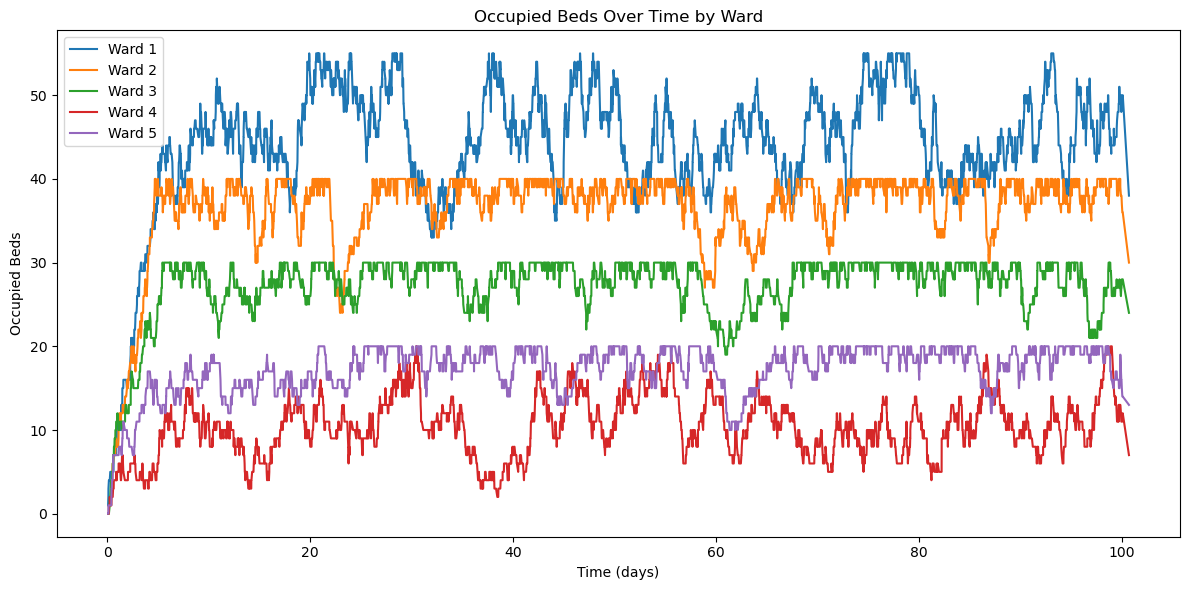

In [1148]:
plt.figure(figsize=(12, 6))
for i in range(occ_bed_hist.shape[1]):
    plt.plot(time_hist, occ_bed_hist[:, i], label=f"Ward {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Occupied Beds")
plt.title("Occupied Beds Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

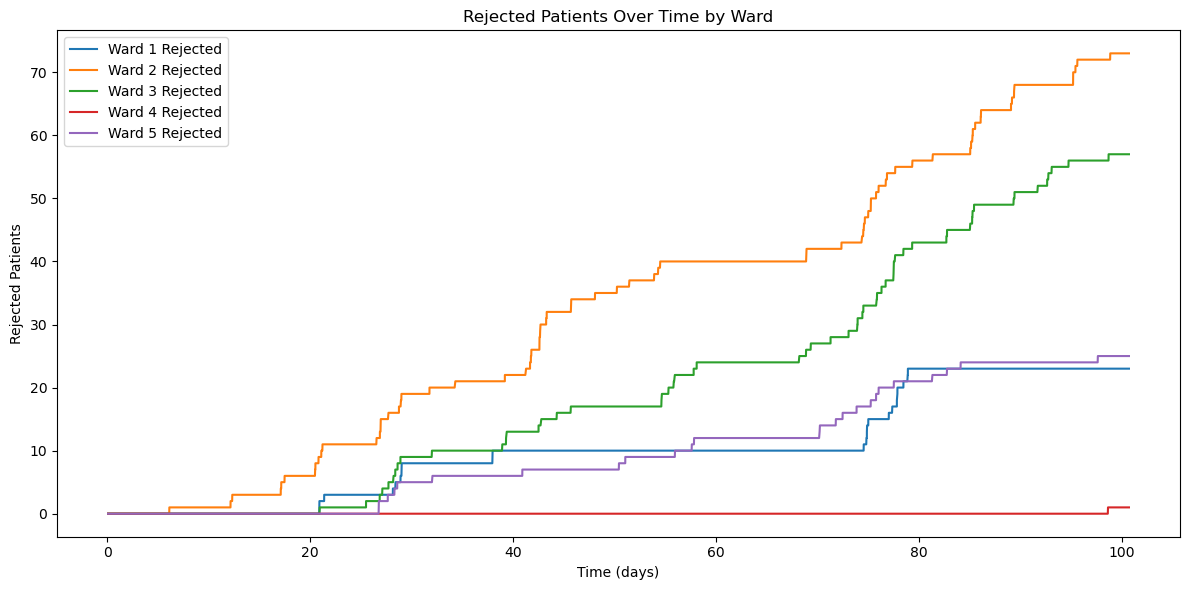

In [1149]:
plt.figure(figsize=(12, 6))
for i in range(rej_hist.shape[1]):
    plt.plot(time_hist, rej_hist[:, i], label=f"Ward {i+1} Rejected")
plt.xlabel("Time (days)")
plt.ylabel("Rejected Patients")
plt.title("Rejected Patients Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

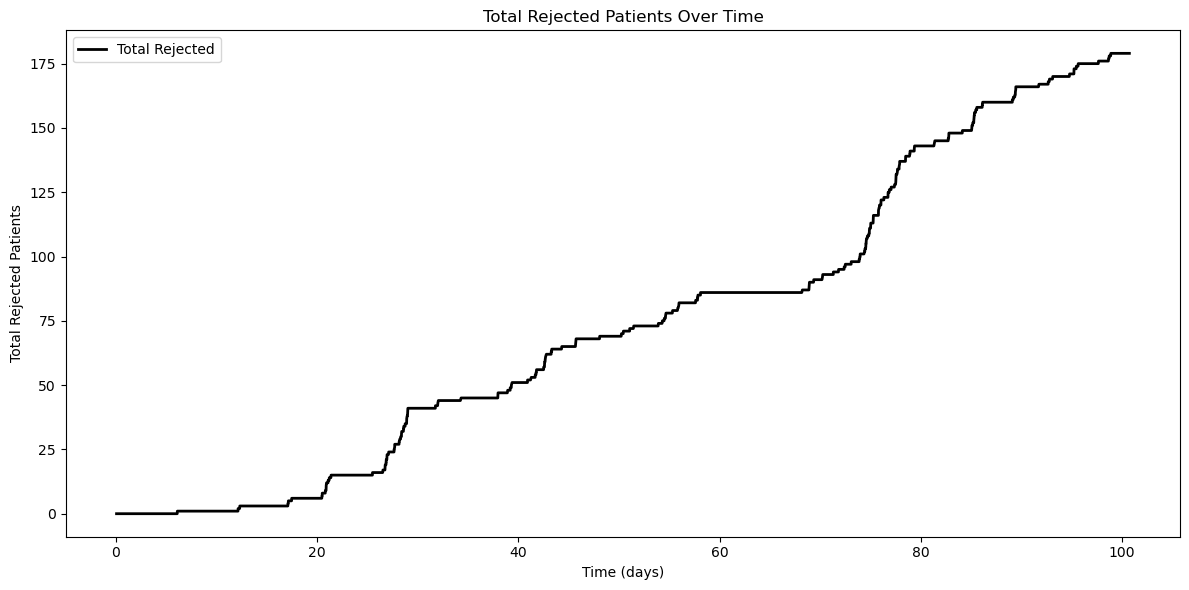

In [1150]:
plt.figure(figsize=(12, 6))
total_rejected = rej_hist.sum(axis=1)
plt.plot(time_hist, total_rejected, label="Total Rejected", color="black", linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Total Rejected Patients")
plt.title("Total Rejected Patients Over Time")
plt.legend()
plt.tight_layout()
plt.show()

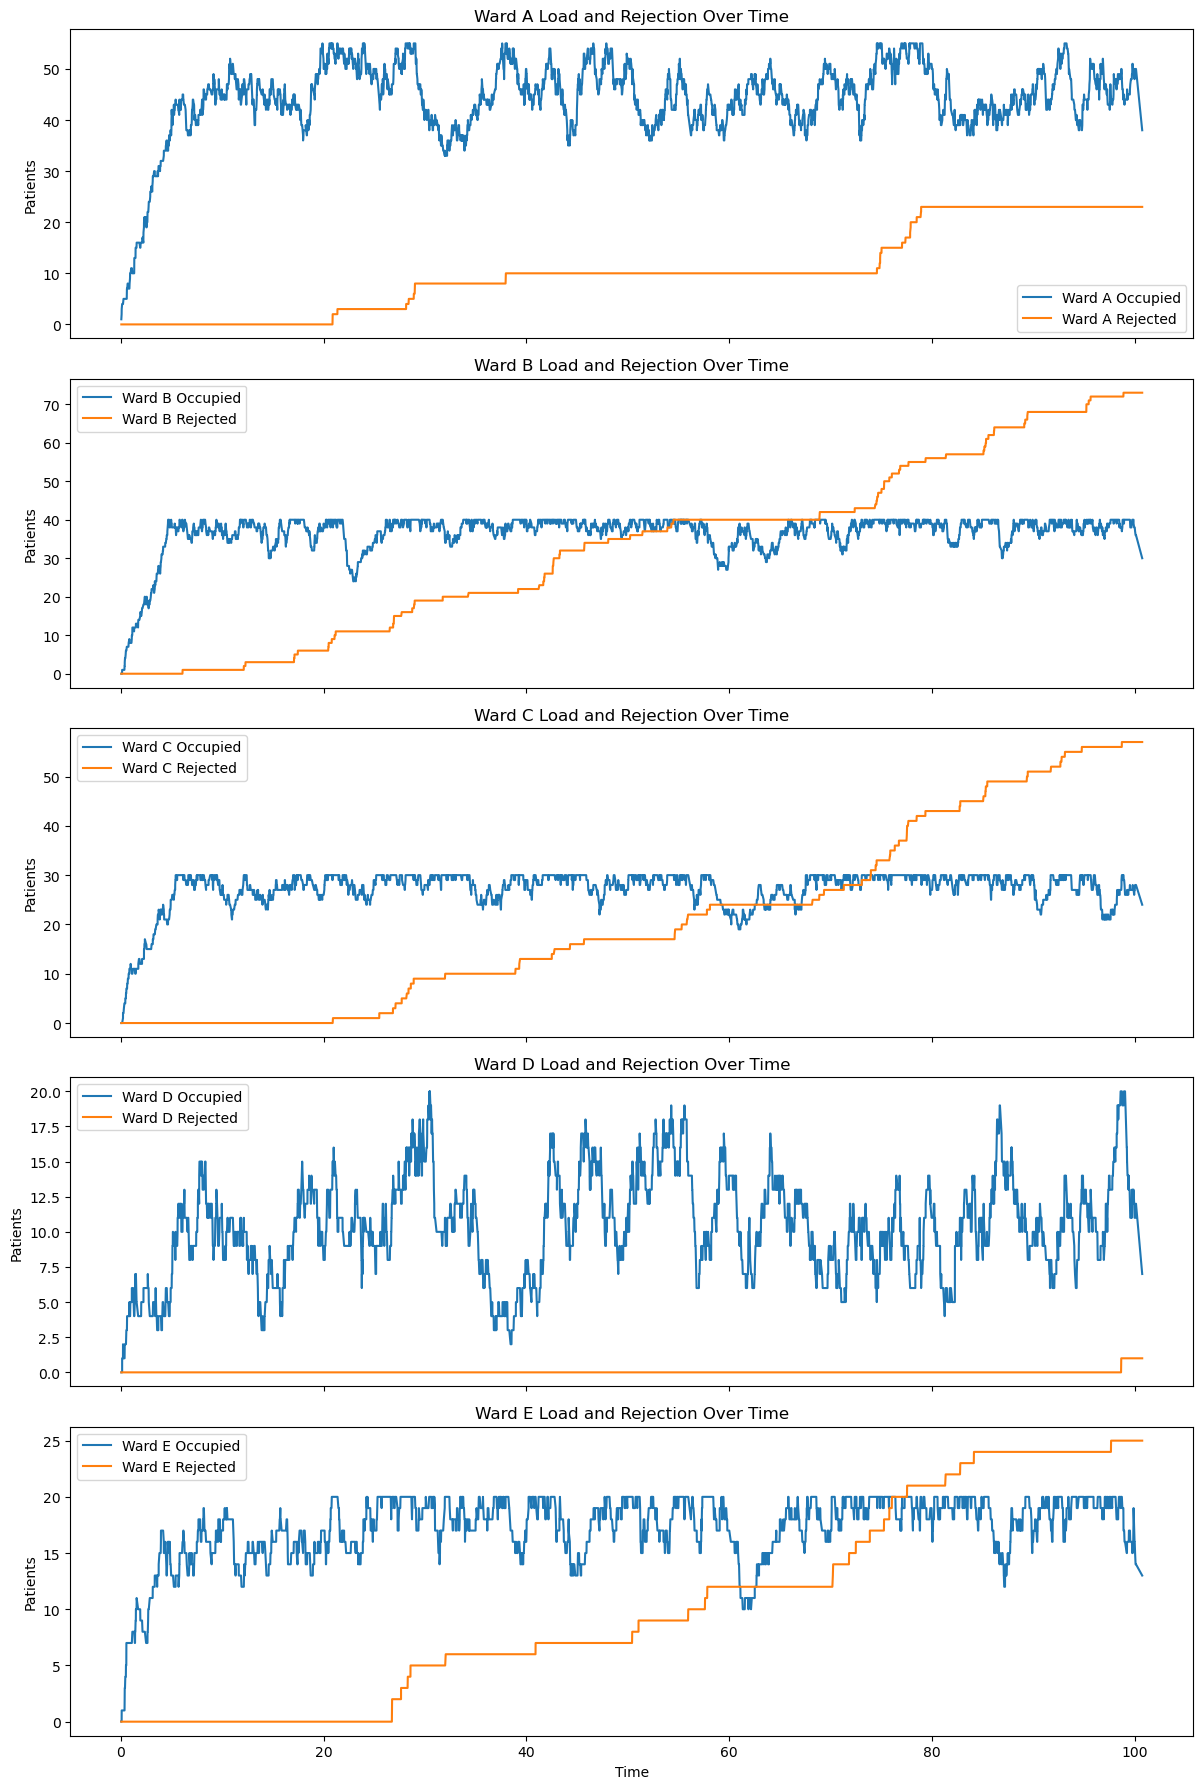

In [1151]:
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True)
ward_names = ['A', 'B', 'C', 'D', 'E']

for idx in range(5):
    axes[idx].plot(time_hist, occ_bed_hist[:, idx], label=f'Ward {ward_names[idx]} Occupied')
    axes[idx].plot(time_hist, rej_hist[:, idx], label=f'Ward {ward_names[idx]} Rejected')
    axes[idx].set_ylabel("Patients")
    axes[idx].set_title(f"Ward {ward_names[idx]} Load and Rejection Over Time")
    axes[idx].legend()

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [1152]:
print(reloc_matrix)

[[ 0  1  2  0 13]
 [56  0 64 51 23]
 [92 28  0 44 48]
 [ 0  0  0  0  0]
 [25  6 35 18  0]]


In [1153]:
def compute_empirical_transition(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    empirical_prob = matrix / row_sums
    return empirical_prob

In [1154]:
print(compute_empirical_transition(reloc_matrix))

[[0.         0.0625     0.125      0.         0.8125    ]
 [0.28865979 0.         0.32989691 0.2628866  0.1185567 ]
 [0.43396226 0.13207547 0.         0.20754717 0.22641509]
 [0.         0.         0.         0.         0.        ]
 [0.29761905 0.07142857 0.41666667 0.21428571 0.        ]]


## Primary Task 2

In [1155]:
P = np.array([
    [0.00, 0.05, 0.10, 0.05, 0.80, 0],  # From A
    [0.20, 0.00, 0.50, 0.15, 0.15, 0],  # From B
    [0.30, 0.20, 0.00, 0.20, 0.30, 0],  # From C
    [0.35, 0.30, 0.05, 0.00, 0.30, 0],  # From D
    [0.20, 0.10, 0.60, 0.10, 0.00, 0],  # From E
    [0.20, 0.20, 0.20, 0.20, 0.20, 0.00]
])

total_bed = 165

bed_capacities = [40, 40, 20, 15, 15, 35]
print("Total bed capacities:", sum(bed_capacities))

lambdas = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]

mean_length_of_stay = [2.9, 4.0, 4.5, 1.4, 3.9, 2.2]

urgency_point = [7, 5, 2, 10, 5]

days_simulation = 100

Total bed capacities: 165


In [1156]:
occ_bed_hist, rej_hist, time_hist, leaves, reloc_matrix, mix_time_arrival = simulate(P, lambdas, mean_length_of_stay, bed_capacities, days_simulation)

In [1157]:
rejected_F = rej_hist[-1, -1]
relocated_F = np.sum(reloc_matrix[-1, :])

print(f"Rejected patients in ward F: {rejected_F}")
print(f"Total patients reallocated from Ward F: {relocated_F}")

Rejected patients in ward F: 31
Total patients reallocated from Ward F: 30


In [1158]:
F_index = 5

total_f_patients = sum(1 for _, pt in mix_time_arrival if pt == F_index)

admitted_to_F = total_f_patients - rejected_F - relocated_F
admission_rate = admitted_to_F / total_f_patients

if admission_rate >= 0.95:
    print(f"Condition met: at least 95% ({round(100 * admission_rate, 2)}%) admitted to Ward F*")
else:
    print("Condition NOT met: only", round(100 * admission_rate, 2), "% admitted to Ward F*")

rejected = rej_hist[-1, :-1]
relocated = np.sum(reloc_matrix[:-1, :], axis=1)
total_point_missed = (rejected + relocated) @ urgency_point

print(f"Total urgency points missed: {total_point_missed}")

Condition met: at least 95% (95.32%) admitted to Ward F*
Total urgency points missed: 6875


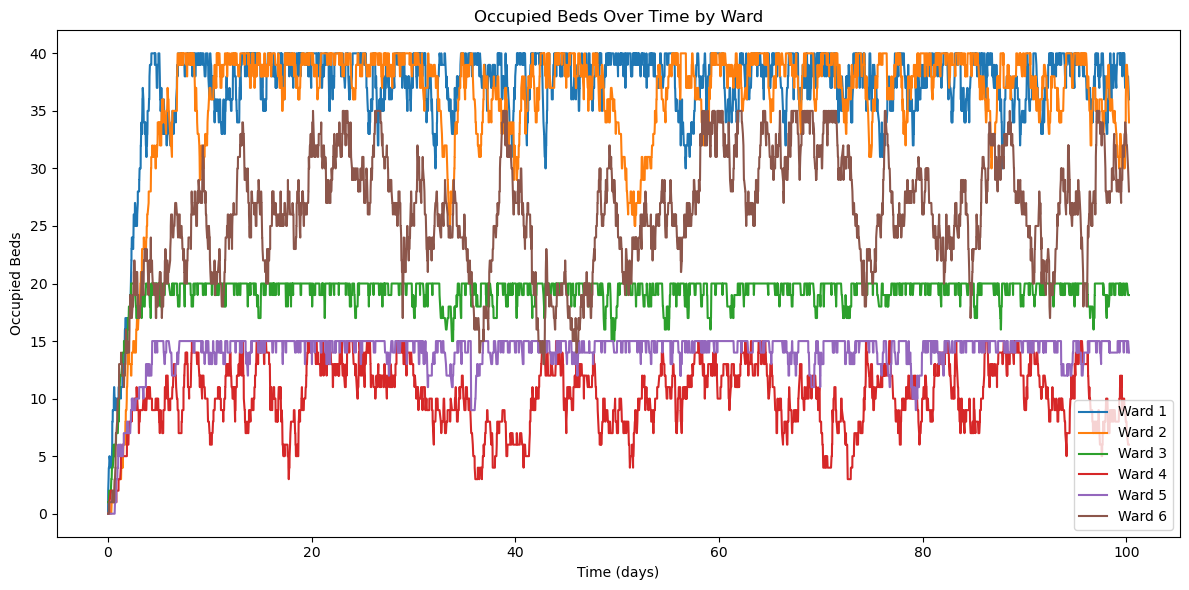

In [1159]:
plt.figure(figsize=(12, 6))
for i in range(occ_bed_hist.shape[1]):
    plt.plot(time_hist, occ_bed_hist[:, i], label=f"Ward {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Occupied Beds")
plt.title("Occupied Beds Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

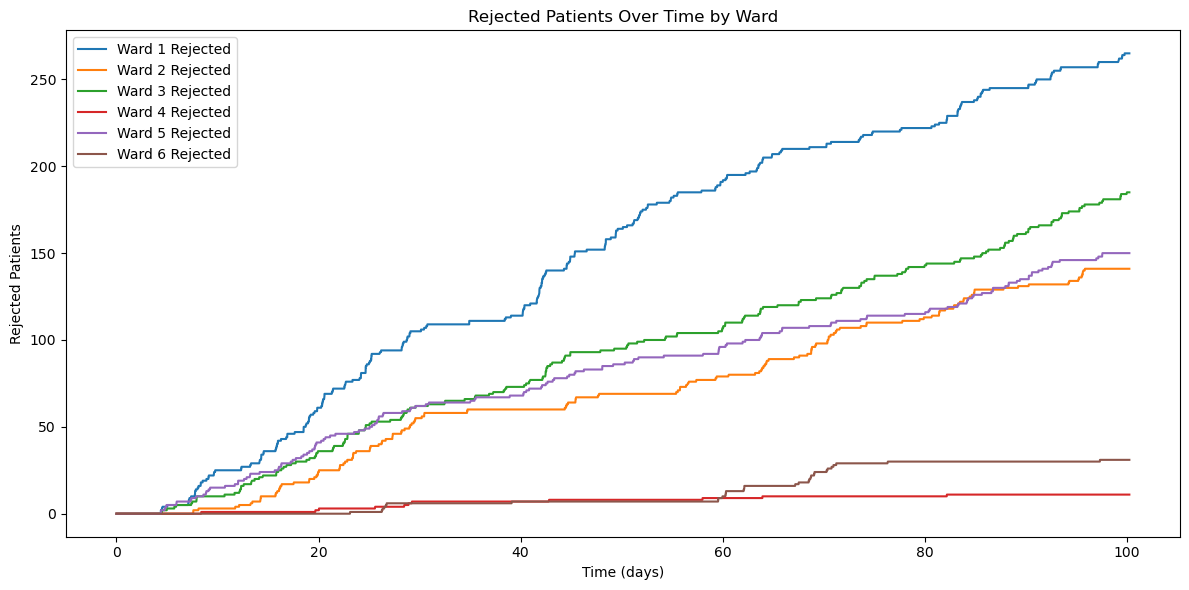

In [1160]:
plt.figure(figsize=(12, 6))
for i in range(rej_hist.shape[1]):
    plt.plot(time_hist, rej_hist[:, i], label=f"Ward {i+1} Rejected")
plt.xlabel("Time (days)")
plt.ylabel("Rejected Patients")
plt.title("Rejected Patients Over Time by Ward")
plt.legend()
plt.tight_layout()
plt.show()

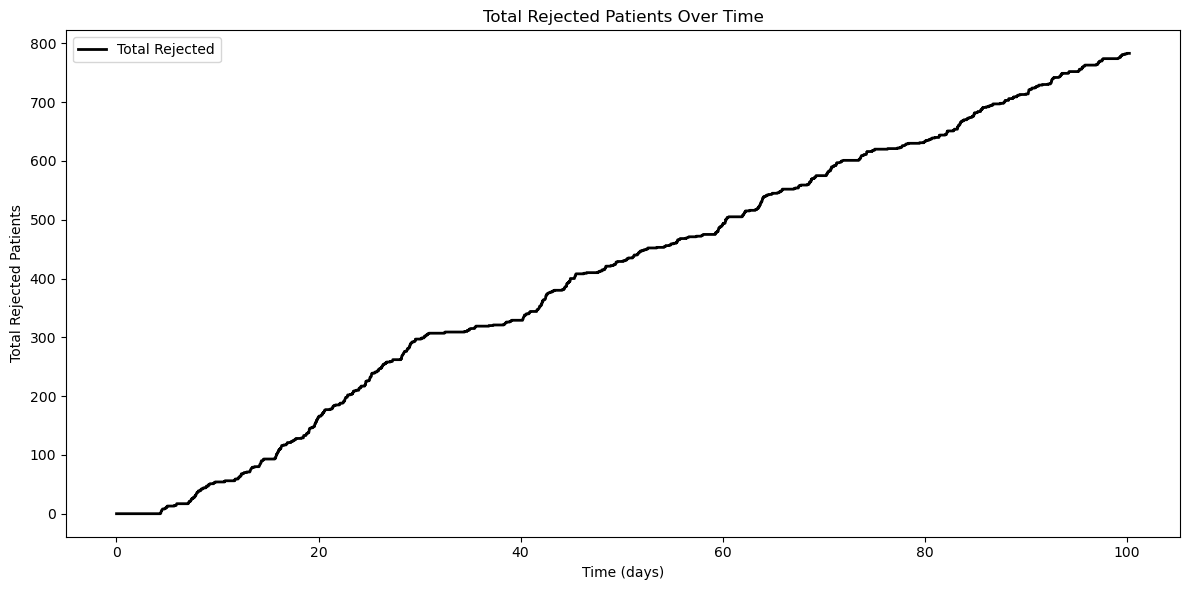

In [1161]:
plt.figure(figsize=(12, 6))
total_rejected = rej_hist.sum(axis=1)
plt.plot(time_hist, total_rejected, label="Total Rejected", color="black", linewidth=2)
plt.xlabel("Time (days)")
plt.ylabel("Total Rejected Patients")
plt.title("Total Rejected Patients Over Time")
plt.legend()
plt.tight_layout()
plt.show()

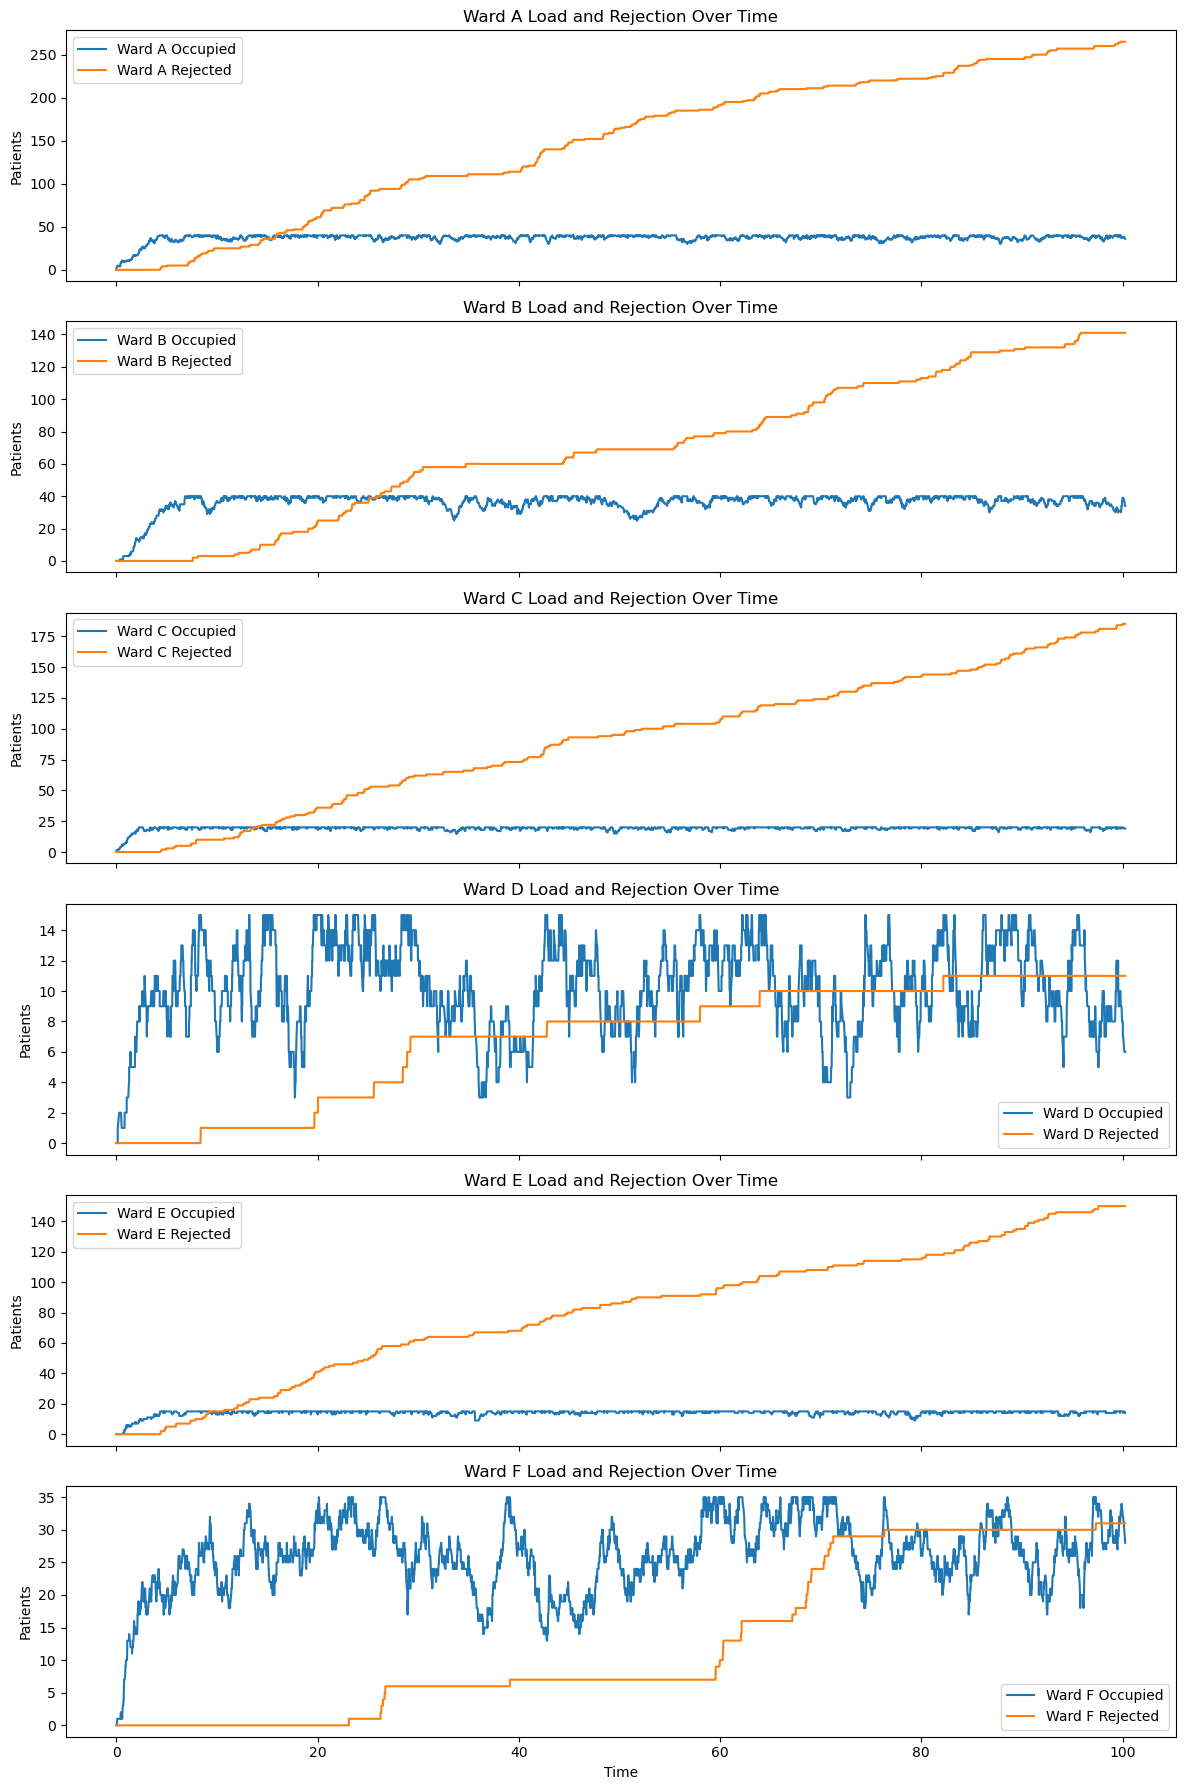

In [1162]:
fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)
ward_names = ['A', 'B', 'C', 'D', 'E', 'F']

for idx in range(6):
    axes[idx].plot(time_hist, occ_bed_hist[:, idx], label=f'Ward {ward_names[idx]} Occupied')
    axes[idx].plot(time_hist, rej_hist[:, idx], label=f'Ward {ward_names[idx]} Rejected')
    axes[idx].set_ylabel("Patients")
    axes[idx].set_title(f"Ward {ward_names[idx]} Load and Rejection Over Time")
    axes[idx].legend()

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [1163]:
print(compute_empirical_transition(reloc_matrix))

[[0.         0.11278195 0.15789474 0.15037594 0.57894737 0.        ]
 [0.3362069  0.         0.29310345 0.29310345 0.07758621 0.        ]
 [0.32919255 0.20807453 0.         0.26397516 0.19875776 0.        ]
 [0.28571429 0.5        0.07142857 0.         0.14285714 0.        ]
 [0.15189873 0.12658228 0.53797468 0.1835443  0.         0.        ]
 [0.2        0.16666667 0.06666667 0.46666667 0.1        0.        ]]
